### Notebook for Figure 3 and relevant data, comparison of 'high' and 'medium' dataset

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import sceptre as spt
from sklearn import metrics
from scipy.stats import gaussian_kde
from scipy.stats import linregress

In [2]:
# create result folder
res_dir = '../results/300ms_vs_500ms/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [3]:
random_state = 1

In [4]:
# set figsize for scanpys scatterplot panels
plt.rcParams['figure.figsize'] = (2, 2)
cellsize= 30 # size to plot cells

In [5]:
# import 300ms and 500ms adata
adata_300 = sc.read('../results/300ms/300ms.h5ad')
adata_500 = sc.read('../results/500ms/500ms.h5ad')

In [6]:
ms3_lib = pd.read_table('../data/library/library_MS3_Proteins.txt')

## Sample-set specific proteins

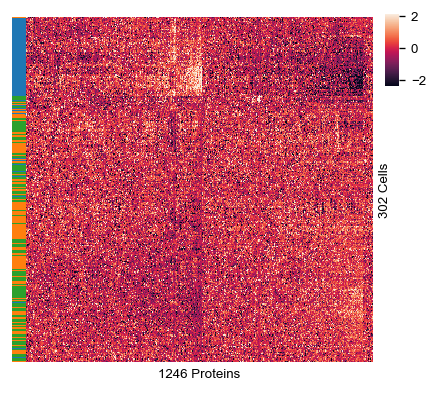

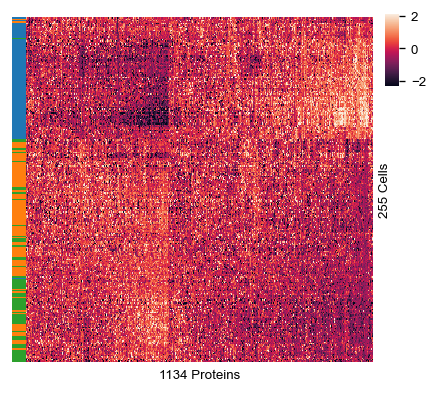

In [7]:
ax = sc.pl.clustermap(adata_300, obs_keys='Sorted Population', metric='correlation', use_raw=False, robust=True, xticklabels=False, yticklabels=False, show=False, cbar_pos=(0.995, .645, .03, .15), figsize=(4, 4))
p = ax.ax_heatmap.set(xlabel='{} Proteins'.format(adata_300.shape[1]), ylabel='{} Cells'.format(adata_300.shape[0]))
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)

ax = sc.pl.clustermap(adata_500, obs_keys='Sorted Population', metric='correlation', use_raw=False, robust=True, xticklabels=False, yticklabels=False, show=False, cbar_pos=(0.995, .645, .03, .15), figsize=(4, 4))
p = ax.ax_heatmap.set(xlabel='{} Proteins'.format(adata_500.shape[1]), ylabel='{} Cells'.format(adata_500.shape[0]))
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)

In [8]:
# silhouette score prog vs lsc
adata_300_slice = adata_300[adata_300.obs['Sorted Population'].isin(['LSC', 'PROG'])]
adata_500_slice = adata_500[adata_500.obs['Sorted Population'].isin(['LSC', 'PROG'])]

silhouette_scores = pd.Series({'300ms': metrics.silhouette_score(adata_300_slice.obsm['X_umap'], adata_300_slice.obs['Sorted Population']),
                               '500ms': metrics.silhouette_score(adata_500_slice.obsm['X_umap'], adata_500_slice.obs['Sorted Population'])})

In [9]:
fc_300 = adata_300.uns['LSC_vs_BLAST']['results']
fc_500 = adata_500.uns['LSC_vs_BLAST']['results']

In [10]:
comp_300 = fc_300.merge(ms3_lib[['Gene Symbol',
                         'Abundance Ratio log2 LSC  BLAST',
                         'Abundance Ratio Adj P-Value LSC  BLAST']].rename(columns={
    'Abundance Ratio log2 LSC  BLAST':'log2foldchange_lib',
    'Abundance Ratio Adj P-Value LSC  BLAST': 'pval_adj_lib'
}), left_on='gene', right_on='Gene Symbol')
comp_300 = comp_300.dropna()

comp_500 = fc_500.merge(ms3_lib[['Gene Symbol',
                         'Abundance Ratio log2 LSC  BLAST',
                         'Abundance Ratio Adj P-Value LSC  BLAST']].rename(columns={
    'Abundance Ratio log2 LSC  BLAST':'log2foldchange_lib',
    'Abundance Ratio Adj P-Value LSC  BLAST': 'pval_adj_lib'
}), left_on='gene', right_on='Gene Symbol')
comp_500 = comp_500.dropna()

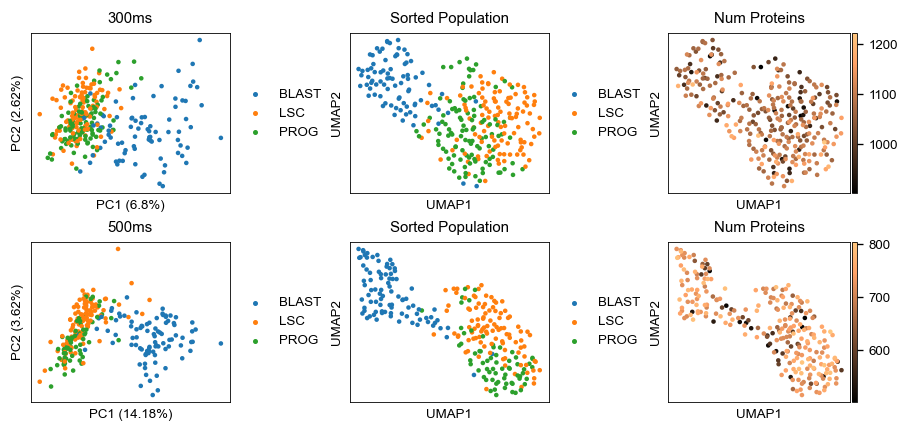

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=3,
                        gridspec_kw=dict(hspace=0.3, wspace=0.6),
                        figsize=(9, 4))

p = sc.pl.pca(adata_300, color=['Sorted Population'], size=cellsize, ncols=2, show=False, ax=axs[0][0], title='300ms', annotate_var_explained=True)
p = sc.pl.pca(adata_500, color=['Sorted Population'], size=cellsize, ncols=2, show=False, ax=axs[1][0], title='500ms', annotate_var_explained=True)

p = sc.pl.umap(adata_300, color=['Sorted Population'], size=cellsize, show=False, ax=axs[0][1])
p = sc.pl.umap(adata_500, color=['Sorted Population'], size=cellsize, show=False, ax=axs[1][1])

p = sc.pl.umap(adata_300, color=['Num Proteins'], cmap='copper', size=cellsize, show=False, ax=axs[0][2])
p = sc.pl.umap(adata_500, color=['Num Proteins'], cmap='copper', size=cellsize, show=False, ax=axs[1][2])

fig.savefig(res_dir + 'specific_embedding.pdf', bbox_inches='tight', transparent=True)

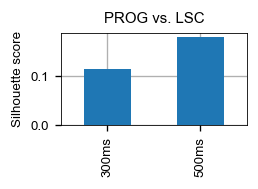

In [12]:
silhouette_scores.plot.bar(title='PROG vs. LSC', figsize=(2,1), grid=True)
plt.ylabel('Silhouette score')
plt.savefig(res_dir + 'specific_silhouette_score.pdf', bbox_inches='tight', transparent=True)

1725
1342


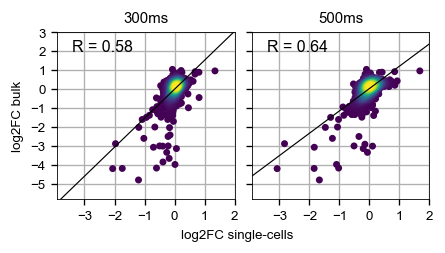

In [13]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(4, 1.8), gridspec_kw={'wspace':0.1})
axs = axs.flatten()
for i, comp in enumerate([comp_300, comp_500]):
    
    print(len(comp))
    x = comp['log2foldchange'].values
    y = comp['log2foldchange_lib'].values
    reg = linregress(x,y)
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    ax = axs[i]
    ax.scatter(x, y, c=z, s=10)
    ax.plot(range(-4, 4), reg.slope*range(-4, 4) + reg.intercept, c='black')
    ax.text(-3.4, 2, 'R = {}'.format(round(reg.rvalue, 2)), size='large')
    ax.set_xticks(range(-5, 5))
    ax.set_yticks(range(-5, 5))
    ax.set_xlim((-3.9, 2))
    ax.set_ylim((-5.8, 3))
    ax.set_title(['300ms', '500ms'][i])
    ax.set_xlabel(' ')
    if i == 0:
        ax.set_ylabel('log2FC bulk')
    ax.grid()
fig.text(0.5, -0.03, 'log2FC single-cells', ha='center', va='top', size=plt.rcParams['axes.labelsize'])
fig.savefig(res_dir + 'all_fold_changes.pdf', bbox_inches='tight', transparent=True)

In [14]:
# only take the top proteins
comp_300_top = comp_300.sort_values('size1', ascending=False).head(400)
print(len(comp_300_top))
comp_500_top = comp_500.sort_values('size1', ascending=False).head(400)
print(len(comp_500_top))

400
400


400
400


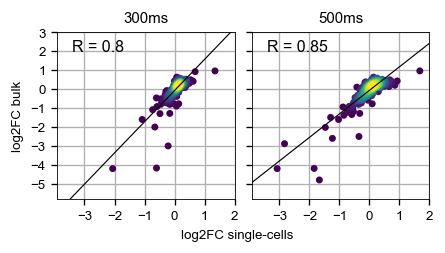

In [15]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(4, 1.8), gridspec_kw={'wspace':0.1})
axs = axs.flatten()
for i, comp in enumerate([comp_300_top, comp_500_top]):
    
    print(len(comp))
    x = comp['log2foldchange'].values
    y = comp['log2foldchange_lib'].values
    reg = linregress(x,y)
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    ax = axs[i]
    ax.scatter(x, y, c=z, s=10)
    ax.plot(range(-4, 4), reg.slope*range(-4, 4) + reg.intercept, c='black')
    ax.text(-3.4, 2, 'R = {}'.format(round(reg.rvalue, 2)), size='large')
    ax.set_xticks(range(-5, 5))
    ax.set_yticks(range(-5, 5))
    ax.set_xlim((-3.9, 2))
    ax.set_ylim((-5.8, 3))
    ax.set_title(['300ms', '500ms'][i])
    ax.set_xlabel(' ')
    if i == 0:
        ax.set_ylabel('log2FC bulk')
    ax.grid()
fig.text(0.5, -0.03, 'log2FC single-cells', ha='center', va='top', size=plt.rcParams['axes.labelsize'])
fig.savefig(res_dir + 'top_fold_changes.pdf', bbox_inches='tight', transparent=True)

In [16]:
# only take significantly changed proteins
comp_300_si = comp_300[(comp_300['pval_adj'] <= 0.05) & (comp_300['pval_adj_lib'] <= 0.05)]
print(len(comp_300_si))
comp_500_si = comp_500[(comp_500['pval_adj'] <= 0.05) & (comp_500['pval_adj_lib'] <= 0.05)]
print(len(comp_500_si))

337
374


337
374


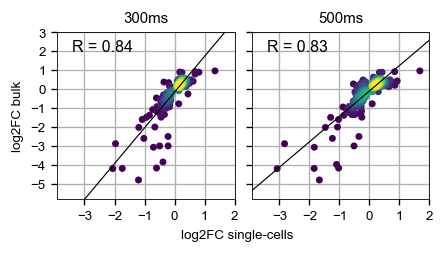

In [17]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(4, 1.8), gridspec_kw={'wspace':0.1})
axs = axs.flatten()
for i, comp in enumerate([comp_300_si, comp_500_si]):
    
    print(len(comp))
    x = comp['log2foldchange'].values
    y = comp['log2foldchange_lib'].values
    reg = linregress(x,y)
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    ax = axs[i]
    ax.scatter(x, y, c=z, s=10)
    ax.plot(range(-4, 4), reg.slope*range(-4, 4) + reg.intercept, c='black')
    ax.text(-3.4, 2, 'R = {}'.format(round(reg.rvalue, 2)), size='large')
    ax.set_xticks(range(-5, 5))
    ax.set_yticks(range(-5, 5))
    ax.set_xlim((-3.9, 2))
    ax.set_ylim((-5.8, 3))
    ax.set_title(['300ms', '500ms'][i])
    ax.set_xlabel(' ')
    if i == 0:
        ax.set_ylabel('log2FC bulk')
    ax.grid()
fig.text(0.5, -0.03, 'log2FC single-cells', ha='center', va='top', size=plt.rcParams['axes.labelsize'])
fig.savefig(res_dir + 'signi_fold_changes.pdf', bbox_inches='tight', transparent=True)

## Overlapping proteins

In [18]:
# keep the overlap between both datasets
intersec = adata_500.var_names.intersection(adata_300.var_names)
# sample from cells to equalize the number of each celltype
min_cells = pd.concat([adata_300.obs['Sorted Population'].value_counts(),adata_500.obs['Sorted Population'].value_counts()], axis=1).min(axis=1)
adata_300_cells = []
adata_500_cells = []
for celltype in min_cells.index:
    adata_300_cells.extend(adata_300.obs[adata_300.obs['Sorted Population']==celltype].sample(min_cells[celltype], random_state=random_state).index.tolist())
    adata_500_cells.extend(adata_500.obs[adata_500.obs['Sorted Population']==celltype].sample(min_cells[celltype], random_state=random_state).index.tolist())
    
adata_300 = adata_300[adata_300_cells, intersec]
adata_500 = adata_500[adata_500_cells, intersec]
adata_300.obs['Num Proteins'] = adata_300.shape[1]
adata_500.obs['Num Proteins'] = adata_500.shape[1]

sc.pp.pca(adata_300)
sc.pp.pca(adata_500)
sc.pp.neighbors(adata_300)
sc.pp.neighbors(adata_500)
sc.tl.umap(adata_300)
sc.tl.umap(adata_500)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


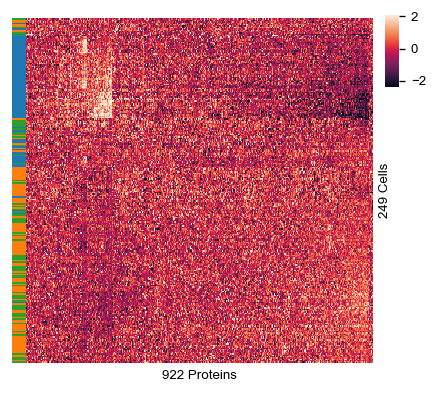

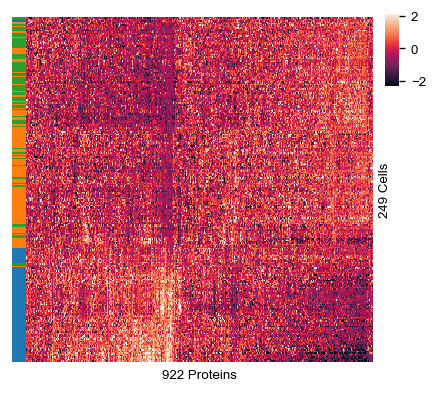

In [19]:
ax = sc.pl.clustermap(adata_300, obs_keys='Sorted Population', metric='correlation', use_raw=False, robust=True, xticklabels=False, yticklabels=False, show=False, cbar_pos=(0.995, .645, .03, .15), figsize=(4, 4))
p = ax.ax_heatmap.set(xlabel='{} Proteins'.format(adata_300.shape[1]), ylabel='{} Cells'.format(adata_300.shape[0]))
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)

ax = sc.pl.clustermap(adata_500, obs_keys='Sorted Population', metric='correlation', use_raw=False, robust=True, xticklabels=False, yticklabels=False, show=False, cbar_pos=(0.995, .645, .03, .15), figsize=(4, 4))
p = ax.ax_heatmap.set(xlabel='{} Proteins'.format(adata_500.shape[1]), ylabel='{} Cells'.format(adata_500.shape[0]))
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)

In [20]:
# silhouette score prog vs lsc
adata_300_slice = adata_300[adata_300.obs['Sorted Population'].isin(['LSC', 'PROG'])]
adata_500_slice = adata_500[adata_500.obs['Sorted Population'].isin(['LSC', 'PROG'])]

silhouette_scores = pd.Series({'300ms': metrics.silhouette_score(adata_300_slice.obsm['X_umap'], adata_300_slice.obs['Sorted Population']),
                               '500ms': metrics.silhouette_score(adata_500_slice.obsm['X_umap'], adata_500_slice.obs['Sorted Population'])})

In [21]:
fc_300 = adata_300.uns['LSC_vs_BLAST']['results']
fc_500 = adata_500.uns['LSC_vs_BLAST']['results']

In [22]:
fc_300 = fc_300.sort_values('size1', ascending=False)
fc_500 = fc_500.sort_values('size1', ascending=False)
intersec = fc_300['gene'][fc_300['gene'].isin(fc_500['gene'])]
intersec

208          LYZ
165          EZR
321      HNRNPAB
172         MCM4
98         PCBP1
          ...   
1858       FADS2
1315    PAFAH1B1
1594      NDUFS2
1487         BID
1641       NCSTN
Name: gene, Length: 1270, dtype: object

In [23]:
fc_300 = fc_300[fc_300['gene'].isin(intersec)]
fc_500 = fc_500[fc_500['gene'].isin(intersec)]

In [24]:
comp_300 = fc_300.merge(ms3_lib[['Gene Symbol',
                         'Abundance Ratio log2 LSC  BLAST',
                         'Abundance Ratio Adj P-Value LSC  BLAST']].rename(columns={
    'Abundance Ratio log2 LSC  BLAST':'log2foldchange_lib',
    'Abundance Ratio Adj P-Value LSC  BLAST': 'pval_adj_lib'
}), left_on='gene', right_on='Gene Symbol')
comp_300 = comp_300.dropna()

comp_500 = fc_500.merge(ms3_lib[['Gene Symbol',
                         'Abundance Ratio log2 LSC  BLAST',
                         'Abundance Ratio Adj P-Value LSC  BLAST']].rename(columns={
    'Abundance Ratio log2 LSC  BLAST':'log2foldchange_lib',
    'Abundance Ratio Adj P-Value LSC  BLAST': 'pval_adj_lib'
}), left_on='gene', right_on='Gene Symbol')
comp_500 = comp_500.dropna()

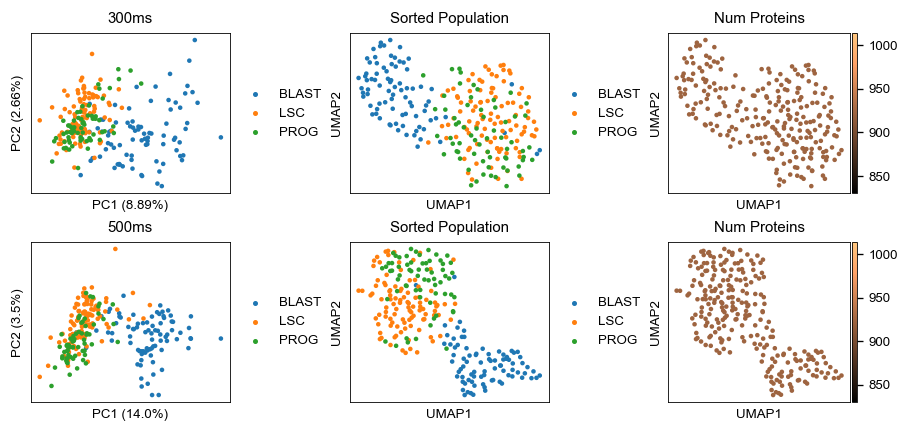

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=3,
                        gridspec_kw=dict(hspace=0.3, wspace=0.6),
                        figsize=(9, 4))

p = sc.pl.pca(adata_300, color=['Sorted Population'], size=cellsize, ncols=2, show=False, ax=axs[0][0], title='300ms', annotate_var_explained=True)
p = sc.pl.pca(adata_500, color=['Sorted Population'], size=cellsize, ncols=2, show=False, ax=axs[1][0], title='500ms', annotate_var_explained=True)

p = sc.pl.umap(adata_300, color=['Sorted Population'], size=cellsize, show=False, ax=axs[0][1])
p = sc.pl.umap(adata_500, color=['Sorted Population'], size=cellsize, show=False, ax=axs[1][1])

p = sc.pl.umap(adata_300, color=['Num Proteins'], cmap='copper', size=cellsize, show=False, ax=axs[0][2])
p = sc.pl.umap(adata_500, color=['Num Proteins'], cmap='copper', size=cellsize, show=False, ax=axs[1][2])
fig.savefig(res_dir + 'overlap_embedding.pdf', bbox_inches='tight', transparent=True)

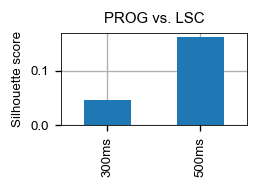

In [26]:
silhouette_scores.plot.bar(title='PROG vs. LSC', figsize=(2,1), grid=True)
plt.ylabel('Silhouette score')
plt.savefig(res_dir + 'overlap_silhouette_score.pdf', bbox_inches='tight', transparent=True)

Text(0.5, -0.03, 'log2FC single-cells')

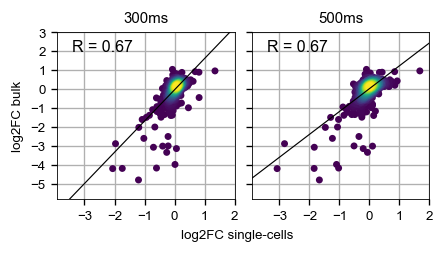

In [27]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(4, 1.8), gridspec_kw={'wspace':0.1})
axs = axs.flatten()
for i, comp in enumerate([comp_300, comp_500]):
    
    x = comp['log2foldchange'].values
    y = comp['log2foldchange_lib'].values
    reg = linregress(x,y)
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    ax = axs[i]
    ax.scatter(x, y, c=z, s=10)
    ax.plot(range(-4, 4), reg.slope*range(-4, 4) + reg.intercept, c='black')
    ax.text(-3.4, 2, 'R = {}'.format(round(reg.rvalue, 2)), size='large')
    ax.set_xticks(range(-5, 5))
    ax.set_yticks(range(-5, 5))
    ax.set_xlim((-3.9, 2))
    ax.set_ylim((-5.8, 3))
    ax.set_title(['300ms', '500ms'][i])
    ax.set_xlabel(' ')
    if i == 0:
        ax.set_ylabel('log2FC bulk')
    ax.grid()
fig.text(0.5, -0.03, 'log2FC single-cells', ha='center', va='top', size=plt.rcParams['axes.labelsize'])

In [28]:
os.system('jupyter nbconvert --to html 300ms_vs_500ms.ipynb --output-dir={}'.format(res_dir))

0